In [201]:
import datetime
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import yfinance as yf

tickers = ['ICICIBANK.NS','SBIN.NS','TCS.NS','RELIANCE.NS','HINDUNILVR.NS']
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days = 5*252)

In [202]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start = start_date,end = end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [203]:
returns = adj_close_df / adj_close_df.shift(1).dropna()

In [204]:
cov_matrix = returns.cov() * 252

In [205]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [206]:
risk_free_rate = .072

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 1) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))

optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [207]:
optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")

Optimal Weights:
ICICIBANK.NS: 0.1730
SBIN.NS: 0.0516
TCS.NS: 0.2740
RELIANCE.NS: 0.1701
HINDUNILVR.NS: 0.3313
Expected Annual Return: 252.1575
Expected Volatility: 0.1445


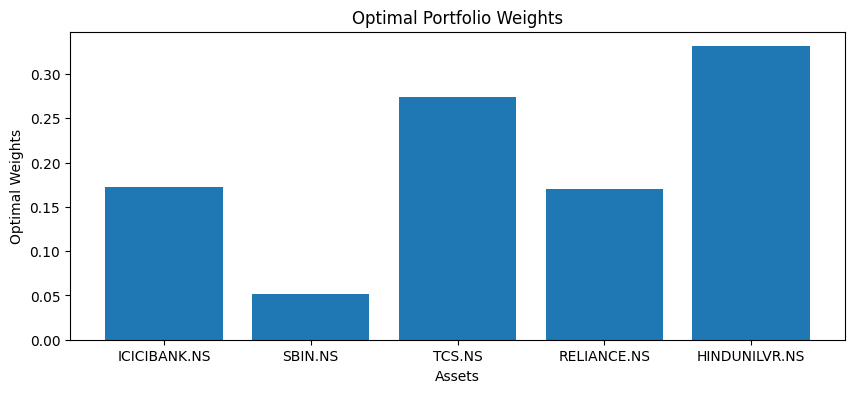

In [208]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()